In [ ]:
import os

if 'datas' not in os.listdir():
    os.makedirs("datas")

## downlod data from web site
!gsutil cp gs://cartoonset_public_files/cartoonset10k.tgz /content/datas/cartoonset10k.tgz

Copying gs://cartoonset_public_files/cartoonset10k.tgz...
- [1 files][454.6 MiB/454.6 MiB]                                                
Operation completed over 1 objects/454.6 MiB.                                    


In [ ]:
## dezip on the tmp dir
!tar -xzvf "/content/datas/cartoonset10k.tgz" -C "/content/datas/"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
cartoonset10k/cs11130198548099864740.csv
cartoonset10k/cs11130198548099864740.png
cartoonset10k/cs11130522928710913906.csv
cartoonset10k/cs11130522928710913906.png
cartoonset10k/cs11130692035407747496.csv
cartoonset10k/cs11130692035407747496.png
cartoonset10k/cs1113080672465802980.csv
cartoonset10k/cs1113080672465802980.png
cartoonset10k/cs11131138722323947780.csv
cartoonset10k/cs11131138722323947780.png
cartoonset10k/cs1113121412202668922.csv
cartoonset10k/cs1113121412202668922.png
cartoonset10k/cs11131333133753359573.csv
cartoonset10k/cs11131333133753359573.png
cartoonset10k/cs1113143340294813643.csv
cartoonset10k/cs1113143340294813643.png
cartoonset10k/cs11131732994961040179.csv
cartoonset10k/cs11131732994961040179.png
cartoonset10k/cs1113191746674328122.csv
cartoonset10k/cs1113191746674328122.png
cartoonset10k/cs11131958805482037869.csv
cartoonset10k/cs11131958805482037869.png
cartoonset10k/cs111326682978

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Charger les données et les deziper

In [ ]:
# !gsutil cp gs://cartoonset_public_files/cartoonset10k.tgz '/content/drive/MyDrive/data_cartoonset'

Copying gs://cartoonset_public_files/cartoonset10k.tgz...
| [1 files][454.6 MiB/454.6 MiB]                                                
Operation completed over 1 objects/454.6 MiB.                                    


In [ ]:
# !tar -xzvf "/content/drive/MyDrive/data_cartoonset/cartoonset10k.tgz" -C "/content/drive/MyDrive/data_cartoonset/"

In [ ]:
!pwd

/content


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "/content/datas/", label_mode=None, image_size=(128, 128), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 10000 files belonging to 1 classes.


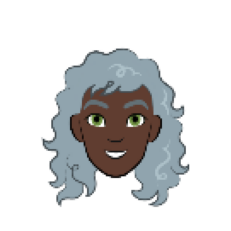

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[4])
    break


# Créer le discriminateur

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
    )
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)           

# Créer le générateur

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(16 * 16 * 128),
        layers.Reshape((16, 16, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32768)             4227072   
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 512)     20

# class GAN

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


# Créer un rappel qui enregistre périodiquement les images générées

In [ ]:
!pwd

/content


In [ ]:
!mkdir datas/generate_img

In [ ]:
!ls datas/

cartoonset10k  cartoonset10k.tgz  generate_img


In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/content/datas/generate_img/generated_img_%03d_%d.png" % (epoch, i))

# Former le model

In [ ]:
epochs = 4  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/4
313/313 [==============================] - 356s 1s/step - d_loss: 0.2145 - g_loss: 4.8409
Epoch 2/4
313/313 [==============================] - 324s 1s/step - d_loss: 0.4304 - g_loss: 2.5001
Epoch 3/4
313/313 [==============================] - 326s 1s/step - d_loss: 0.3827 - g_loss: 1.7516
Epoch 4/4
313/313 [==============================] - 325s 1s/step - d_loss: 0.2116 - g_loss: 2.5537


Text(0.5, 1.0, 'epochs = 1')

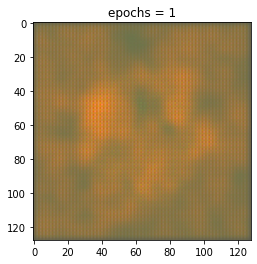

In [ ]:
image = '/content/datas/generate_img/generated_img_000_1.png'

img = cv2.imread(image)
plt.imshow(img)
plt.title('epochs = 1')

Text(0.5, 1.0, 'epochs = 4')

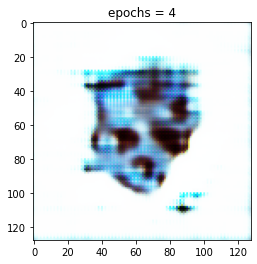

In [ ]:
image = '/content/datas/generate_img/generated_img_003_1.png'

img = cv2.imread(image)
plt.imshow(img)
plt.title('epochs = 4')

In [ ]:
epochs = 50  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/50
313/313 [==============================] - 312s 992ms/step - d_loss: 0.3459 - g_loss: 1.8461
Epoch 2/50
313/313 [==============================] - 324s 1s/step - d_loss: 0.5136 - g_loss: 1.1956
Epoch 3/50
313/313 [==============================] - 325s 1s/step - d_loss: 0.6427 - g_loss: 0.9471
Epoch 4/50
313/313 [==============================] - 326s 1s/step - d_loss: 0.6058 - g_loss: 0.9554
Epoch 5/50
313/313 [==============================] - 327s 1s/step - d_loss: 0.5910 - g_loss: 1.0383
Epoch 6/50
313/313 [==============================] - 331s 1s/step - d_loss: 0.5488 - g_loss: 1.0962
Epoch 7/50
313/313 [==============================] - 332s 1s/step - d_loss: 0.5389 - g_loss: 1.1389
Epoch 8/50
313/313 [==============================] - 332s 1s/step - d_loss: 0.5019 - g_loss: 1.2429
Epoch 9/50
313/313 [==============================] - 331s 1s/step - d_loss: 0.4680 - g_loss: 1.3082
Epoch 10/50
313/313 [==============================] - 333s 1s/step - d_loss: 0.4819 - g

Text(0.5, 1.0, 'image')

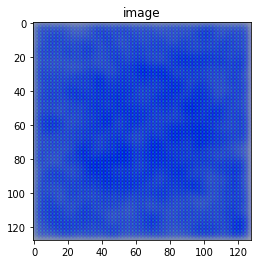

In [ ]:
image = 'drive/MyDrive/data_cartoonset/generate_img/generated_img_001_1.png'

img = cv2.imread(image)
plt.imshow(img)
plt.title('image')

Text(0.5, 1.0, 'image')

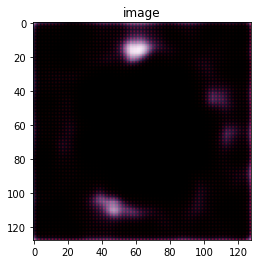

In [ ]:
image = 'drive/MyDrive/data_cartoonset/generate_img/generated_img_009_1.png'

img = cv2.imread(image)
plt.imshow(img)
plt.title('image')

Text(0.5, 1.0, 'image')

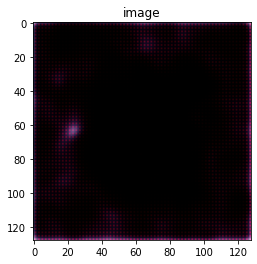

In [ ]:
image = 'drive/MyDrive/data_cartoonset/generate_img/generated_img_009_5.png'

img = cv2.imread(image)
plt.imshow(img)
plt.title('image')

In [ ]:
epochs = 2  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)
gan.save_weights('drive/MyDrive/data_cartoonset/model.h5') # always save your weights after training or during training

Epoch 1/2
10/10 [==============================] - 912s 88s/step - d_loss: 0.2953 - g_loss: 1.3975
Epoch 2/2
10/10 [==============================] - 903s 90s/step - d_loss: 0.5408 - g_loss: 0.7892


# Utilisation du dataset complet

In [ ]:
dataset1 = keras.preprocessing.image_dataset_from_directory(
    "/content/datas/", label_mode=None, image_size=(128, 128), batch_size=32
)
dataset1 = dataset1.map(lambda x: x / 255.0)

Found 10000 files belonging to 2 classes.


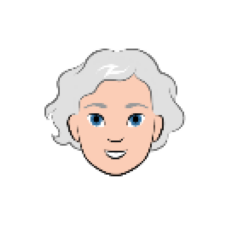

In [ ]:
for x in dataset1:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


In [ ]:
epochs = 50  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset1, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)
gan.save_weights('/content/datas/model.h5') # always save your weights after training or during training

Epoch 1/50
313/313 [==============================] - 367s 1s/step - d_loss: 0.3653 - g_loss: 2.8991
Epoch 2/50
313/313 [==============================] - 328s 1s/step - d_loss: 0.4740 - g_loss: 1.5599
Epoch 3/50
313/313 [==============================] - 327s 1s/step - d_loss: 0.3653 - g_loss: 1.9297
Epoch 4/50
313/313 [==============================] - 327s 1s/step - d_loss: 0.2256 - g_loss: 2.6083
Epoch 5/50
313/313 [==============================] - 326s 1s/step - d_loss: 0.2814 - g_loss: 1.9421
Epoch 6/50
313/313 [==============================] - 325s 1s/step - d_loss: 0.4296 - g_loss: 1.3836
Epoch 7/50
313/313 [==============================] - 325s 1s/step - d_loss: 0.5362 - g_loss: 1.1349
Epoch 8/50
313/313 [==============================] - 325s 1s/step - d_loss: 0.5819 - g_loss: 1.0130
Epoch 9/50
313/313 [==============================] - 326s 1s/step - d_loss: 0.5445 - g_loss: 1.1134
Epoch 10/50
313/313 [==============================] - 328s 1s/step - d_loss: 0.5139 - g_lo